### Motivation: In any game, there are countless strategies to enhance the gameplay experience, and one critical aspect is the game's content. In-game purchases, such as items or vehicles, play a key role in shaping this content. Each game features its own unique system for in-game item pricing. Therefore, I decided to analyze the reasonableness of vehicle prices.
### Why choose this data: Vehicles are a central component of gameplay in GTA 5, a masterpiece in the gaming industry over the past decade. Additionally, the dataset is extensive enough to support a comprehensive analysis.    

### Date sources: https://www.gtabase.com/grand-theft-auto-v/

### Data Preprocessing

In [8]:
import pandas as pd
from scipy.stats import zscore

# input
df1 = pd.read_csv('vehicle_data_batch_1.csv')
df2 = pd.read_csv('vehicle_data_batch_2.csv')
df3 = pd.read_csv('vehicle_data_batch_3.csv')

# combine
df = pd.concat([df1, df2, df3], axis = 0)
# df.columns

# choose the variables
needed_variable = ['title', 'vehicle_class', 'acquisition', 'race_availability', 'top_speed_in_game', 'seats',
                   'weight_in_kg', 'drive_train', 'gears', 'bulletproof', 'weapon1_resistance', 'weapon2_resistance',
                   'weapon3_resistance', 'weapon4_resistance', 'weapon5_resistance',
                   'speed', 'acceleration', 'braking', 'handling', 'price']
df['vehicle_class'] = df['vehicle_class'].replace({'Utility': 0, 'SUVs': 0, 'Motorcycles': 0, 'Sedans': 0, 'Sports Classics': 0, 
                                                        'Off-Road': 0, 'Sports' : 0, 'Super' : 0, 'Muscle' : 0,  'Open Wheel' : 0, 'Coupes' : 0,
                                                        'Vans': 0, 'Compacts': 0, 'Service': 0, 'Emergency': 0,
                                                        'Commercial': 0,  'Industrial': 0, 'Cycles': 0, 
                                                        'Military' : 1,
                                                        'Planes': 2
                                                            }) ## 0 : Car, 1 : Military, 2 : Plane
df_new = df[needed_variable].copy()

# variable preprocess
df_new['title'] = df_new['title'].replace('GTA 5: ', '', regex=True)
df_new['top_speed_in_game'] = df_new['top_speed_in_game'].str.extract(r'(\d+\.?\d*)').astype(float)
df_new['weight_in_kg'] = df_new['weight_in_kg'].str.replace(r'[^\d.]', '', regex=True).astype(float)
df_new['speed'] = df_new['speed'].str.extract(r'(\d+\.?\d*)').astype(float)
df_new['acceleration'] = df_new['acceleration'].str.extract(r'(\d+\.?\d*)').astype(float)
df_new['braking'] = df_new['braking'].str.extract(r'(\d+\.?\d*)').astype(float)
df_new['handling'] = df_new['handling'].str.extract(r'(\d+\.?\d*)').astype(float)
df_new['price'] = df_new['price'].str.replace(r'[^\d.]', '', regex=True).astype(float)
df_new.rename(columns = {'weapon1_resistance':'missiles_resistance'}, inplace=True)
df_new.rename(columns = {'weapon2_resistance':'explosive_weapon_resistance'}, inplace=True)
df_new.rename(columns = {'weapon3_resistance':'explosive_bullet_resistance'}, inplace=True)
df_new.rename(columns = {'weapon4_resistance':'tank_cannon_resistance'}, inplace=True)
df_new.rename(columns = {'weapon5_resistance':'aircraft_trailer_resistance'}, inplace=True)
# df_new['drive_train'] = df_new['drive_train'].replace({'RWD': 1})
# df_new['drive_train'] = df_new['drive_train'].fillna(0)
df_new['gears'] = df_new['gears'].fillna(0)

## encoding
# df_new['bulletproof'].unique()
df_new = pd.get_dummies(df_new, columns=['vehicle_class', 'acquisition', 'race_availability', 'bulletproof'], dtype=int)
df_new['vehicle_class'] = df['vehicle_class']

# df_new.describe()
# df_new.shape
# df['vehicle_class'].unique()
# df[df['vehicle_class'] == 'Industrial']

## check na
# df_new.isnull().values.any()

In [9]:
## check correlation and multicollinearity
df_new['speed'].corr(df_new['top_speed_in_game'])
df_new['acceleration'].corr(df_new['speed'])

0.6645156066512954

### Drop speed feature to avoid multicollinearity effect

### Analyze which features affect vehicle price the most and Construct models to perdict vehicle price

### Linear Regression

In [10]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Prepare the data
X = df_new.drop(['speed', 'title', 'price', 'vehicle_class', 'drive_train'], axis=1)
y = df_new['price']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_with_const = sm.add_constant(X_scaled)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Fit the model
model = sm.OLS(y_scaled, X_scaled_with_const).fit()
model_summary = model.summary2().tables[1]

# Filter for p-values less than 0.05 and extract coefficients
filtered_summary = model_summary[model_summary['P>|t|'] < 0.05]
significant_coefs = filtered_summary['Coef.']  
sorted_coefs = significant_coefs.sort_values(ascending=False)

print("\nSignificant Coefficients (sorted):")
print(sorted_coefs)



Significant Coefficients (sorted):
acquisition_Legendary Motorsport                               0.703545
acquisition_Southern S.A. Super Autos                          0.557978
acquisition_Warstock Cache & Carry                             0.531395
acquisition_Benny's Original Motor Works                       0.293484
race_availability_Special Vehicle Races                        0.224655
vehicle_class_2                                                0.216120
handling                                                       0.183886
acceleration                                                   0.175438
top_speed_in_game                                              0.157955
bulletproof_Windows are unbreakable                            0.100388
bulletproof_Bulletproof from the rear (rear has no windows)    0.074777
race_availability_Can be used in Races                        -0.135735
vehicle_class_0                                               -0.164951
Name: Coef., dtype: float64


### The coefficient table for vehicles indicates that acquisition method, acceleration, handling, top speed, and vehicle class are the features most strongly associated with the price of a vehicle. This provides valuable insights for game developers when determining pricing strategies. If any pricing appears unreasonable, the weights of these features can be adjusted to ensure a more balanced and fair pricing model.

MSE of linear regression model: 713983615661.0288
R_square of linear regression model: 0.35589150656117996
Correlation Coefficient: 0.6351


Text(0.5, 1.0, 'Model perdiction result with Diagonal Line')

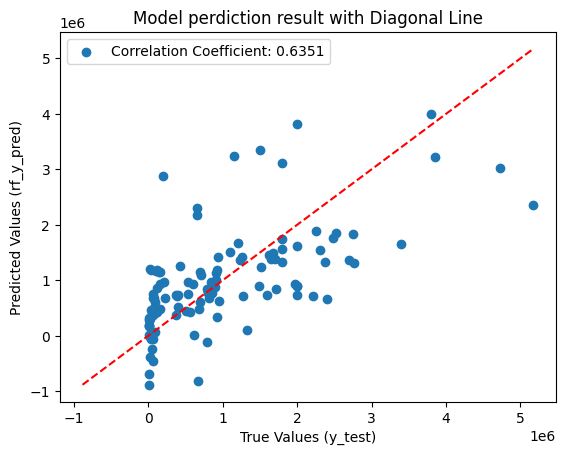

In [11]:
## trainning model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

## scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## fit the linear model
LR_model = LinearRegression()
LR_model.fit(X_train_scaled, y_train)

## test the model
y_pred = LR_model.predict(X_test_scaled)

# Calculate MSE and R-square
MSE = mean_squared_error(y_test, y_pred)
print('MSE of linear regression model:', MSE)
R_square = r2_score(y_test, y_pred)
print('R_square of linear regression model:', R_square)

# correlation coeficient
y_test = y_test.ravel() 
y_pred = y_pred.ravel()  
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

plt.scatter(y_test, y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(y_pred))  # Find the minimum value
max_val = max(max(y_test), max(y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')
# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")

### Lasso

Coefficients: [  347631.17875783    79219.88283063   162920.36475723  -165139.2625069
  -141805.83307228 -3982575.56924784  4489943.74185863  -152769.88235197
  -206650.64993312   161620.59166484    65269.14900153   222276.04122445
   -27968.76518321        0.            61228.73753325   -84069.89772947
   -36596.36901844    31834.73012795  -124097.1257517   -161993.63157275
   106159.49203026        0.           102537.08757698    60185.63052826
  -247391.72559497   -39084.58674031   -39456.03604563   194063.91648574
        0.             7119.4115505    -27198.92138137    97060.98002815
    68998.17866919   -82541.59116268    38490.40725104   -10115.69588138
    89604.28572715    69370.01270485   -49217.98548341    52385.42534755
   -47935.34067624   -37214.09084338        0.           -20544.93215292
   -53082.8087799         0.            10930.19866659   -24618.2561594
   -31348.93611319   -71540.46885216   -39486.04245992   114940.58463338
        0.        ]
MSE of lasso model:

Text(0.5, 1.0, 'Model perdiction result with Diagonal Line')

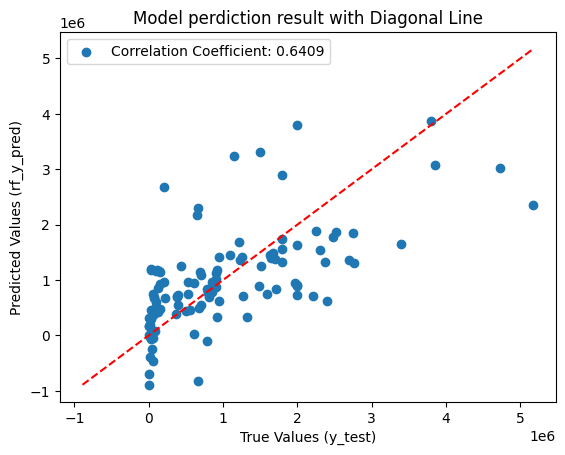

In [12]:
## using lasso to select the important feature
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=100, max_iter=100000, random_state=10)
lasso_model.fit(X_train_scaled, y_train)
lasso_y_pred = lasso_model.predict(X_test_scaled)

# Calculate MSE
MSE = mean_squared_error(y_test, lasso_y_pred)
print(f"Coefficients: {lasso_model.coef_}")
print('MSE of lasso model:', MSE)

r2 = r2_score(y_test, lasso_y_pred)
print(f"Decision Tree R² Score: {r2:.4f}")

# correlation coeficient
y_test = y_test.ravel() 
lasso_y_pred = lasso_y_pred.ravel()  
correlation_matrix = np.corrcoef(y_test, lasso_y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

plt.scatter(y_test, lasso_y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(lasso_y_pred))  # Find the minimum value
max_val = max(max(y_test), max(lasso_y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')

# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")

### Random Forest

MSE of Random Forest model: 541096028146.4206
Random Forest R² Score: 0.5119
Correlation Coefficient: 0.7324


Text(0.5, 1.0, 'Model perdiction result with Diagonal Line')

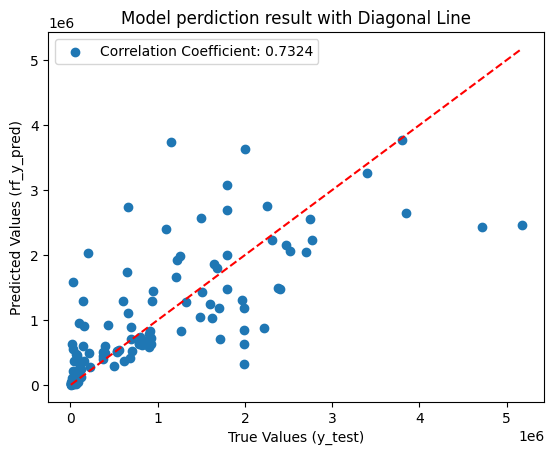

In [13]:
## Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=10)
rf_model.fit(X_train_scaled, y_train)
rf_y_pred = rf_model.predict(X_test_scaled)

## MSE
MSE = mean_squared_error(y_test, rf_y_pred)
print('MSE of Random Forest model:', MSE)

r2 = r2_score(y_test, rf_y_pred)
print(f"Random Forest R² Score: {r2:.4f}")

# ## feature importance
# print(f"Random Forest feature importance:")
# importances = rf_model.feature_importances_
# feature_names = X_train.columns
# # Create a DataFrame
# feature_importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importances
# })
# # Sort by importance (descending order)
# feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
# # Reset index for clean display
# feature_importance_df = feature_importance_df.reset_index(drop=True)
# # Display the table
# print(feature_importance_df.to_string(index=False))

# correlation coeficient
y_test = y_test.ravel() 
rf_y_pred = rf_y_pred.ravel()  
correlation_matrix = np.corrcoef(y_test, rf_y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

plt.scatter(y_test, rf_y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(rf_y_pred))  # Find the minimum value
max_val = max(max(y_test), max(rf_y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')

# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")

### CNN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE of TensorFlow model: 566931751331.8751
R_squared of TensorFlow model: 0.4885519104035406


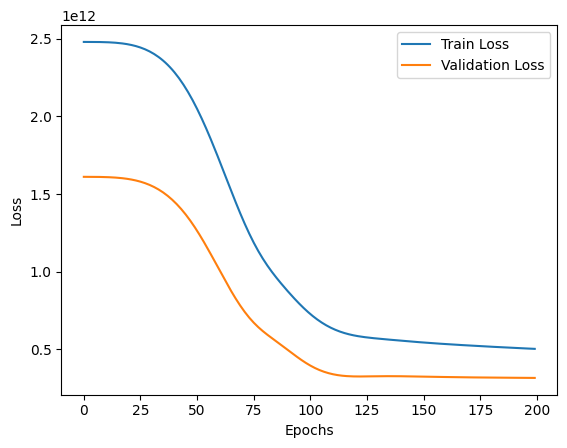

Correlation Coefficient: 0.7021


Text(0.5, 1.0, 'Model perdiction result with Diagonal Line')

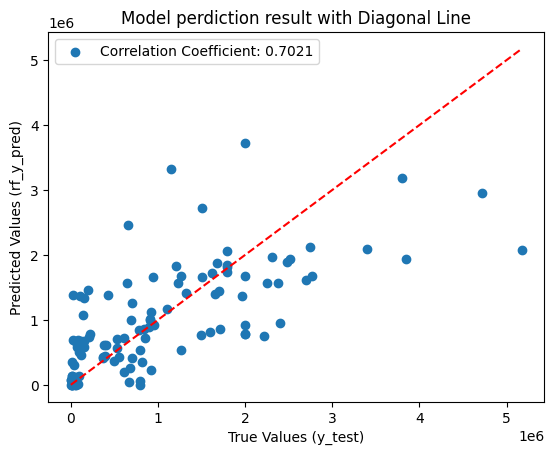

In [14]:
import tensorflow as tf
from tensorflow.keras import regularizers


# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer with the number of features
    tf.keras.layers.Dense(64, activation='relu'),             # Hidden layer with 64 neurons and ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),             # Another hidden 
    tf.keras.layers.Dense(1)                                  # Output layer 
])


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), 
              loss='mean_squared_error',
              metrics=['mse'])

y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Train the model
history = model.fit(X_train_scaled, y_train_np, epochs=200, batch_size=512, validation_split=0.2, verbose=0)
# Evaluate the model on the test set
test_loss, test_mse = model.evaluate(X_test_scaled, y_test_np, verbose=0)
# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics
MSE = mean_squared_error(y_test_np, y_pred)
R_square = r2_score(y_test_np, y_pred)

print('MSE of TensorFlow model:', MSE)
print('R_squared of TensorFlow model:', R_square)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# correlation coeficient
y_test = y_test.ravel() 
y_pred = y_pred.ravel()  
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

plt.scatter(y_test, y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(y_pred))  # Find the minimum value
max_val = max(max(y_test), max(y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')

# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")

### From the R-squared results across all models, I observed that the linear model does not fit the data well, indicating that the relationship within the data is more nonlinear. In contrast, Random Forest and CNN models provide the best performance for this dataset

### Seprate to three cluster for different typr of vehicle

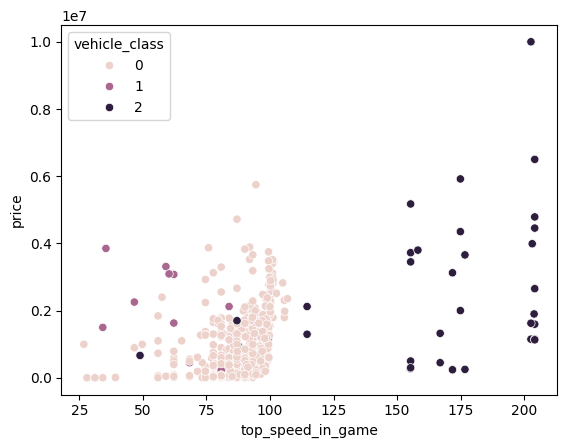

In [15]:
import seaborn as sns

# Scatter plot with hue (colors according to vehicle class)
# print(df_new.columns)
sns.scatterplot(data=df_new, x= 'top_speed_in_game', y='price', hue='vehicle_class')
# plt.xlim([0,5000])

# Display the plot
plt.show()


### There are different clusters: class_0 (car) and class_1 (military vehicle) tend to have lower prices than class_2 (plane). Therefore, try separating the vehicle groups (plane and car) and see if the model performs better.

### Model only for car

In [16]:
# Filter for cars
df_car = df_new[df_new['vehicle_class'] == 0]
df_car = df_car.reset_index(drop=True)

X = df_car.drop(['speed', 'title', 'price', 'vehicle_class', 'drive_train'], axis=1)
y = df_car['price']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_with_const = sm.add_constant(X_scaled)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Fit the model
model = sm.OLS(y_scaled, X_scaled_with_const).fit()

model_summary = model.summary2().tables[1]
filtered_summary = model_summary[model_summary['P>|t|'] < 0.05]
significant_coefs = filtered_summary['Coef.']  
sorted_coefs = significant_coefs.sort_values(ascending=False)

print("\nSignificant Coefficients (sorted):")
print(sorted_coefs)



Significant Coefficients (sorted):
acquisition_Legendary Motorsport                                                                          8.373273e-01
acquisition_Southern S.A. Super Autos                                                                     6.715619e-01
acquisition_Warstock Cache & Carry                                                                        5.313626e-01
acquisition_Can be stolen / found                                                                         4.453548e-01
acquisition_Benny's Original Motor Works                                                                  3.474898e-01
handling                                                                                                  2.929675e-01
race_availability_Special Vehicle Races                                                                   2.692318e-01
acceleration                                                                                              1.833961e-01
bulletproof_

### Linear Regression(car only)

MSE of linear regression model: 471424368202.1213
R_square of linear regression model: 0.48021924158923734
Correlation Coefficient: 0.7097


Text(0.5, 1.0, 'Model perdiction result with Diagonal Line')

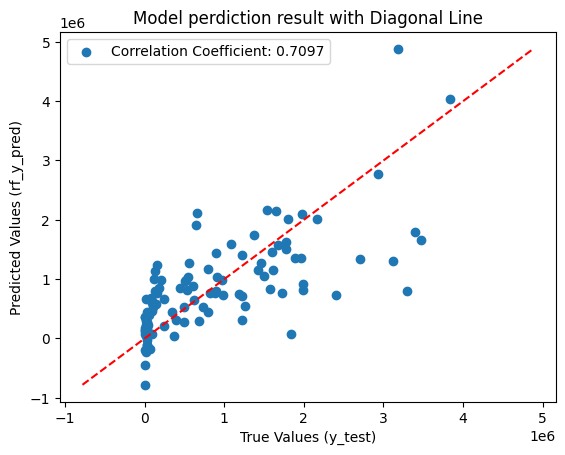

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

## scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## fit the linear model
LR_model = LinearRegression()
LR_model.fit(X_train_scaled, y_train)

## test the model
y_pred = LR_model.predict(X_test_scaled)

# Calculate MSE
MSE = mean_squared_error(y_test, y_pred)
print('MSE of linear regression model:', MSE)

# Calculate R-squared
R_square = r2_score(y_test, y_pred)
print('R_square of linear regression model:', R_square)

# correlation coeficient
y_test = y_test.ravel() 
y_pred = y_pred.ravel()  
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

plt.scatter(y_test, y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(y_pred))  # Find the minimum value
max_val = max(max(y_test), max(y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')

# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")

### Lasso(car only)

MSE of lasso model: 465319074868.5719
Lasso R² Score: 0.4870
Correlation Coefficient: 0.7128


Text(0.5, 1.0, 'Model perdiction result with Diagonal Line')

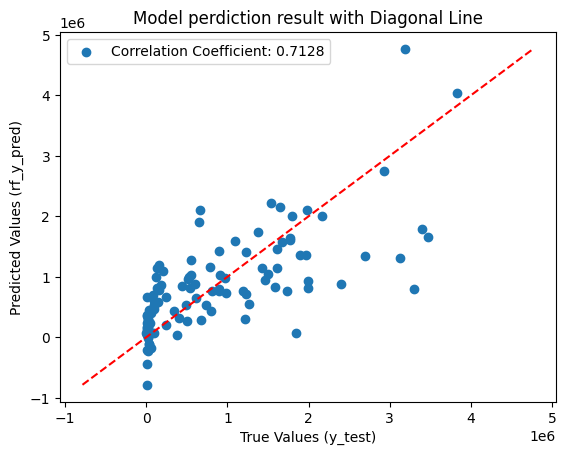

In [18]:
lasso_model = Lasso(alpha=100, max_iter=100000, random_state=10)
lasso_model.fit(X_train_scaled, y_train)
lasso_y_pred = lasso_model.predict(X_test_scaled)

# Calculate MSE
MSE = mean_squared_error(y_test, lasso_y_pred)
# print(f"Coefficients: {lasso_model.coef_}")
print('MSE of lasso model:', MSE)

r2 = r2_score(y_test, lasso_y_pred)
print(f"Lasso R² Score: {r2:.4f}")

# correlation coeficient
y_test = y_test.ravel() 
y_pred = y_pred.ravel()  
correlation_matrix = np.corrcoef(y_test, lasso_y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

plt.scatter(y_test, lasso_y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(lasso_y_pred))  # Find the minimum value
max_val = max(max(y_test), max(lasso_y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')

# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")

### Random Forest(car only)

MSE of Random Forest model: 362719253632.23157
Random Forest R² Score: 0.6001
Correlation Coefficient: 0.7822


Text(0.5, 1.0, 'Model perdiction result with Diagonal Line')

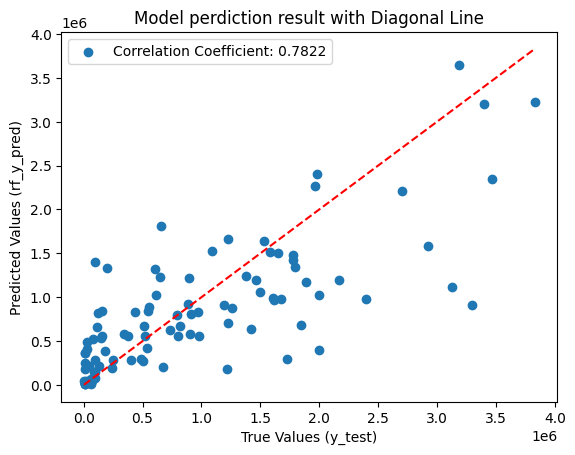

In [19]:
## Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=10)
rf_model.fit(X_train_scaled, y_train)
rf_y_pred = rf_model.predict(X_test_scaled)

## MSE and R-square
MSE = mean_squared_error(y_test, rf_y_pred)
print('MSE of Random Forest model:', MSE)
r2 = r2_score(y_test, rf_y_pred)
print(f"Random Forest R² Score: {r2:.4f}")

# correlation coeficient
y_test = y_test.ravel() 
y_pred = y_pred.ravel()  
correlation_matrix = np.corrcoef(y_test, rf_y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

plt.scatter(y_test, rf_y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(rf_y_pred))  # Find the minimum value
max_val = max(max(y_test), max(rf_y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')

# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")

### CNN(car only)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE of TensorFlow model: 392149279966.0769
R_squared of TensorFlow model: 0.567625977994396
Correlation Coefficient: 0.7605


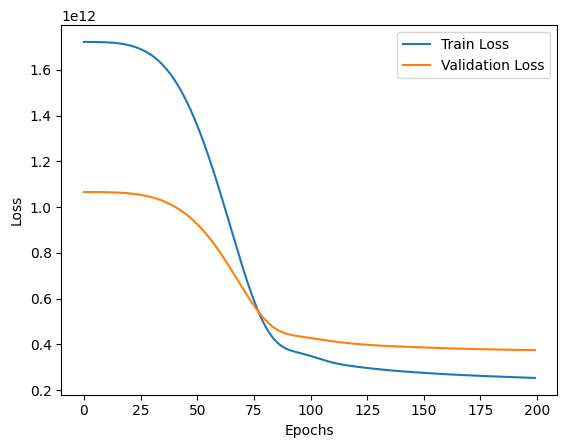

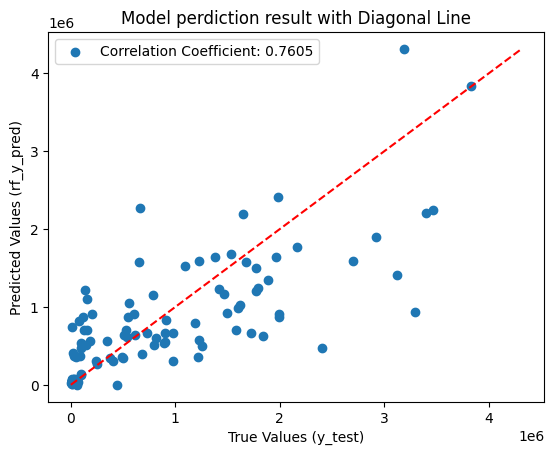

In [20]:
import tensorflow as tf
from tensorflow.keras import regularizers

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)), 
    tf.keras.layers.Dense(64, activation='relu'),             
    tf.keras.layers.Dense(32, activation='relu'),           
    tf.keras.layers.Dense(1)                               
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), 
              loss='mean_squared_error',
              metrics=['mse'])

# Convert labels to numpy arrays (if not already)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Train the model
history = model.fit(X_train_scaled, y_train_np, epochs=200, batch_size=512, validation_split=0.2, verbose=0)
test_loss, test_mse = model.evaluate(X_test_scaled, y_test_np, verbose=0)
# Predict 
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics
MSE = mean_squared_error(y_test_np, y_pred)
R_square = r2_score(y_test_np, y_pred)
print('MSE of TensorFlow model:', MSE)
print('R_squared of TensorFlow model:', R_square)

# correlation coeficient
y_test = y_test.ravel() 
y_pred = y_pred.ravel()
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.scatter(y_test, y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(y_pred))  # Find the minimum value
max_val = max(max(y_test), max(y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')
# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")
plt.show()

#### After excluding only the vehicle category and focusing solely on cars, the model shows a noticeable improvement(random forest model R-square: 0.51 to 0.60). This suggests that separating cars and planes into distinct models and fitting them individually could yield better performance.

## try to add in class 1

## Random Forest(car and military vehicle)

MSE of Random Forest model: 369291183124.3587
Random Forest R² Score: 0.6535
Correlation Coefficient: 0.8144


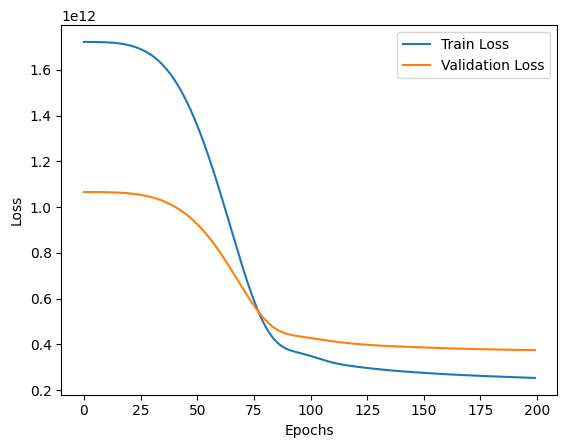

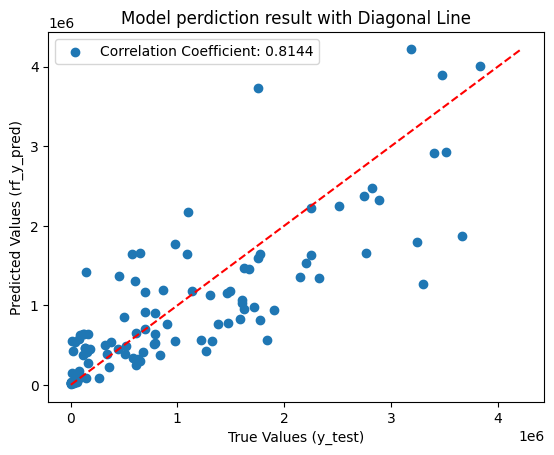

In [21]:
df_all_car = df_new[(df_new['vehicle_class'] == 0) | (df_new['vehicle_class'] == 1)]
df_all_car = df_all_car.reset_index(drop=True)
X = df_all_car.drop(['title', 'price', 'vehicle_class' ,'vehicle_class_0','vehicle_class_1','vehicle_class_2', 'speed','drive_train'], axis=1) 
y = df_all_car['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

## scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=10)
rf_model.fit(X_train_scaled, y_train)
rf_y_pred = rf_model.predict(X_test_scaled)

## MSE
MSE = mean_squared_error(y_test, rf_y_pred)
print('MSE of Random Forest model:', MSE)

r2 = r2_score(y_test, rf_y_pred)
print(f"Random Forest R² Score: {r2:.4f}")

# correlation coeficient
y_test = y_test.ravel() 
rf_y_pred = rf_y_pred.ravel()
correlation_matrix = np.corrcoef(y_test, rf_y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.scatter(y_test, rf_y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(rf_y_pred))  # Find the minimum value
max_val = max(max(y_test), max(rf_y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')
# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")
plt.show()

## CNN(car and military vehicle)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019B7DFFAD40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MSE of TensorFlow model: 479925538958.657
R_squared of TensorFlow model: 0.5496478972211131


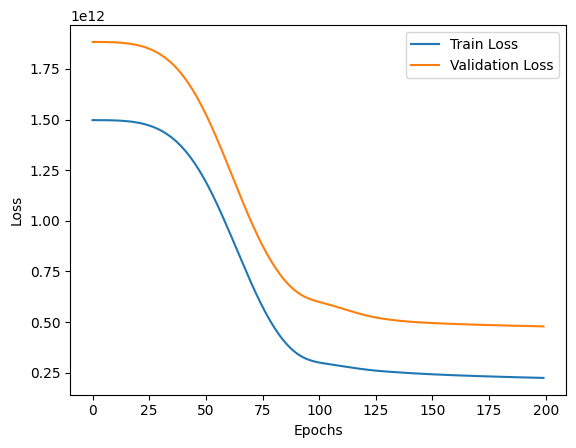

Correlation Coefficient: 0.7467


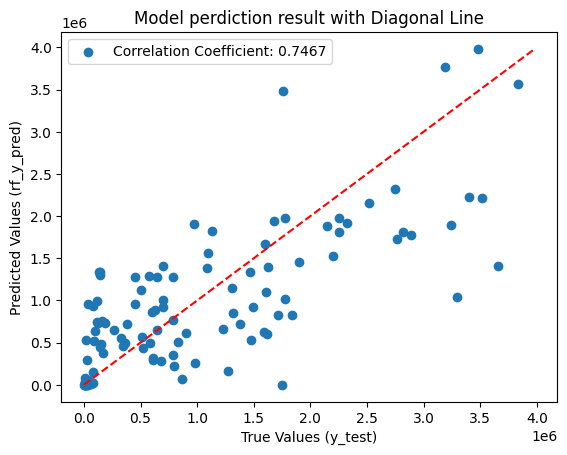

In [22]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)), 
    tf.keras.layers.Dense(64, activation='relu'),          
    tf.keras.layers.Dense(32, activation='relu'),             
    tf.keras.layers.Dense(1)                              
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), 
              loss='mean_squared_error',
              metrics=['mse'])

# Convert labels to numpy arrays (if not already)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Train the model
history = model.fit(X_train_scaled, y_train_np, epochs=200, batch_size=512, validation_split=0.2, verbose=0)
test_loss, test_mse = model.evaluate(X_test_scaled, y_test_np, verbose=0)
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics
MSE = mean_squared_error(y_test_np, y_pred)
R_square = r2_score(y_test_np, y_pred)

print('MSE of TensorFlow model:', MSE)
print('R_squared of TensorFlow model:', R_square)

# training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# correlation coeficient
y_test = y_test.ravel() 
y_pred = y_pred.ravel()
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation Coefficient: {correlation_coefficient:.4f}")

plt.scatter(y_test, y_pred)
# Add the diagonal line (y = x)
min_val = min(min(y_test), min(y_pred))  # Find the minimum value
max_val = max(max(y_test), max(y_pred))  # Find the maximum value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit (y = x)')
plt.legend( [f"Correlation Coefficient: {correlation_coefficient:.4f}"], loc='upper left')
# Add labels, title
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (rf_y_pred)")
plt.title("Model perdiction result with Diagonal Line")
plt.show()


#### The result shows that after adding class_1(Military vehicle), the model predict even better(slightly) than before adding it(random forest model R-square: 0.60 to 0.65). Hence , calss_0 and class_1 have the similar pricing setting strategy

## simple vehicle recommending system

### Implementing Scaled and PCA to avoid curse of dimensionality
### Use the BallTree method to find the vehicles that most closely match the player's requirements(by L2 distance) 

In [23]:
from sklearn.neighbors import BallTree
from sklearn.decomposition import PCA

# Prepare the feature set
feature = df_new.drop(['speed', 'title', 'vehicle_class','drive_train'], axis=1)
title = df_new['title']
feature = feature.set_index(title)
test_data = feature.iloc[0]
feature = feature.drop(feature.index[0]).reset_index(drop=True)

#StandardScaler
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature)
feature_scaled = pd.DataFrame(feature_scaled, columns=feature.columns)

# Dimensionality reduction with PCA
pca = PCA(n_components=20)
data_reduced = pca.fit_transform(feature_scaled)

# Build Ball Tree
tree = BallTree(data_reduced, metric='euclidean')
test_data_scaled = scaler.fit_transform(test_data.values.reshape(1, -1))
test_data_scaled = pd.DataFrame(test_data_scaled, columns=feature.columns)
query_point_reduced = pca.transform(test_data_scaled) 
dist, ind = tree.query(query_point_reduced, k=1)  # k=1 for nearest neighbor search

# Output
nearest_neighbor_index = ind[0][0]
nearest_neighbor_title = df_new['title'].iloc[nearest_neighbor_index]
print(f"Nearest neighbor title (vehicle name): {nearest_neighbor_title}, Distance: {dist[0][0]}")

Nearest neighbor title (vehicle name): Dinka Blista Kanjo, Distance: 1.4443763359468889


### The Dinka Blista Kanjo is the vehicle that best matches the requirements.

## Discovery:
1. Feature Importance for Pricing Strategy
    - Key features: Acquisition method, acceleration, handling, top speed, and vehicle class have the strongest correlation with vehicle price. This suggests that for game developers, focusing on these factors when setting vehicle prices will likely provide the most realistic and balanced pricing.
    - Adjusting weights: If certain pricing appears too high or low, adjusting the weights of these features can help ensure more reasonable price predictions. For example, if top speed is weighted too heavily, vehicles with high speed might be priced excessively.

2. Model Performance and Fit
    - Linear Model: The linear model’s poor performance (low R-squared) indicates that the relationships between the features and the target variable (price) are more complex and nonlinear, suggesting that linear regression is not the best fit for this dataset.
    - Random Forest & CNN: The Random Forest and CNN models offer the best performance, likely due to their ability to capture nonlinear relationships and interactions between features. Random Forest, in particular, seems to handle this dataset well, as shown by the improvements in R-squared.

3. Separating Vehicle Types
    - Class separation (cars and planes): Separating vehicles into distinct groups (e.g., cars and planes) led to a noticeable improvement in performance (Random Forest model R-squared improved from 0.51 to 0.60). This shows that different vehicle categories may have distinct price-setting patterns, and separating them allows the model to learn more accurately.
    - Class_0 and Class_1 similarities: After adding military vehicles (class_1), the model's performance slightly improved (R-squared increased from 0.60 to 0.65). This suggests that military vehicles share more similar pricing patterns with cars (class_0) than with planes (class_2), which could be valuable for pricing strategies.

### What this model may help:
1. Evaluating the reasonableness of in-game item pricing and adjusting feature weights as necessary based on player feedback and data analysis.
2. Implementing a system that allows players to create customized items and utilize an in-game trading system, enabling better evaluation of item prices through market dynamics.
3. Developing a recommendation system based on players' purchasing behavior and preferences to suggest in-game items tailored to their interests.